In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [2]:
import json
from datetime import datetime

In [3]:
import xy

***采用自上而下的 factor mimicking，共构建了增长、生活端通胀、生产端通胀、无风险利率、信用利差、期限利差、汇率等 7 个高频宏观因子。***  
1.其中factor mimicking 是指构建一个资产组合，使该组合同比收益率走势与宏观指标同比增速走势较为接近；  
2.“自上而下”是指从数学统计和经济学逻辑出发，确定各宏观维度代理资产。对于代理资产，我们采用同比波动率倒数加权的方法，构建宏观因子组合。  
  
ps:高频宏观因子为投资者提供了一个可直接投资宏观观点的工具，也可以视作买方的宏观预期指数。  

![示例](mimicking_assets.jpg)

![示例](mimicking_process.jpg)

In [4]:
def read_json_from_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [4]:
def timestamp_to_date_string(timestamp_str):
    # Convert the timestamp string to an integer (assuming it's in milliseconds)
    timestamp = int(timestamp_str)

    # Convert the Unix timestamp to a datetime object
    # Here, we divide by 1000 to convert milliseconds to seconds
    datetime_obj = datetime.fromtimestamp(timestamp / 1000)

    # Format the datetime object as a string in your desired format
    date_string = datetime_obj.strftime('%Y-%m-%d')  # Change the format as needed

    return date_string

def trans_keys(data_dict):
    date_lst = []
    for timestamp_str in data_dict.keys():
        date_str = timestamp_to_date_string(timestamp_str)
        date_lst.append(date_str)
    
    Ser = pd.Series(dict(zip(date_lst,data_dict.values())))
    
    return Ser

## 增长预期

In [6]:
file_path = 'BondCG7_10.txt'
data_dict = read_json_from_file(file_path)
CGBond7_10 = trans_keys(data_dict)

In [7]:
CUI = pd.read_csv('CUI.csv',index_col=0)
HSI = pd.read_csv('HSI.csv',index_col=0)
CRBI = pd.read_csv('CRBI.csv',index_col=0)

In [82]:
HSI_yoy = HSI.rolling(10).mean().pct_change(252).iloc[:,0]
CRBI_yoy = CRBI.rolling(10).mean().pct_change(252).iloc[:,0]
CUI_yoy = CUI.rolling(10).mean().pct_change(252).iloc[:,0]
CGBond7_10_yoy = (CGBond7_10.rolling(10).mean().pct_change(252))

growth_yoy = pd.concat([
    HSI_yoy.rename('HSI_yoy'),
    CRBI_yoy.rename('CRBI_yoy'),
    CUI_yoy.rename('CUI_yoy'),
    CGBond7_10_yoy.rename('CGBond7_10_yoy'),
],axis=1)

In [106]:
weight_HSI = 1/HSI.rolling(10).mean().pct_change(252).rolling(20).std().iloc[:,0]
weight_CRBI = 1/CRBI.rolling(10).mean().pct_change(252).rolling(20).std().iloc[:,0]
weight_CUI = 1/CUI.rolling(10).mean().pct_change(252).rolling(20).std().iloc[:,0]
weight_CGBond7_10 = 1/CGBond7_10.rolling(10).mean().pct_change(252).rolling(252).std()

growth_weight = pd.concat([
    weight_HSI.rename('HSI'),
    weight_CRBI.rename('CRBI'),
    weight_CUI.rename('CUI'),
    weight_CGBond7_10.rename('CGBond7_10'),
],axis=1)

In [107]:
def Singlation(x):
    return x / x.sum()

In [108]:
growth_weight.dropna().T.apply(Singlation)

,2017-03-01,2017-03-02,2017-03-03,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-13,2017-03-14,...,2023-06-15,2023-06-16,2023-06-20,2023-06-21,2023-06-26,2023-06-27,2023-06-28,2023-06-29,2023-06-30,2023-07-03
HSI,0.152282,0.160250,0.170177,0.183715,0.203422,0.230394,0.259861,0.286443,0.307574,0.318296,...,0.128405,0.131476,0.140128,0.145254,0.160747,0.186890,0.230959,0.280264,0.329848,0.384976
CRBI,0.408498,0.383586,0.351677,0.317819,0.290598,0.265160,0.236293,0.210550,0.187064,0.170879,...,0.187945,0.194729,0.202570,0.212337,0.254899,0.240340,0.206316,0.169774,0.141156,0.119742
CUI,0.294104,0.315846,0.341456,0.366034,0.374743,0.368415,0.359156,0.347601,0.340010,0.333658,...,0.290473,0.276387,0.257185,0.250527,0.227024,0.221985,0.216098,0.208392,0.196874,0.178156
CGBond7_10,0.145115,0.140317,0.136690,0.132432,0.131237,0.136030,0.144691,0.155406,0.165351,0.177167,...,0.393177,0.397407,0.400118,0.391882,0.357330,0.350785,0.346628,0.341569,0.332122,0.317127


In [109]:
HSI_yod = HSI.rolling(10).mean().pct_change(1).iloc[:,0]
CRBI_yod = CRBI.rolling(10).mean().pct_change(1).iloc[:,0]
CUI_yod = CUI.rolling(10).mean().pct_change(1).iloc[:,0]
CGBond7_10_yod = -CGBond7_10.rolling(10).mean().pct_change(1)

growth_yod = pd.concat([
    HSI_yod.rename('HSI'),
    CRBI_yod.rename('CRBI'),
    CUI_yod.rename('CUI'),
    CGBond7_10_yod.rename('CGBond7_10'),
],axis=1)

In [110]:
(growth_weight.dropna().T.apply(Singlation))

,2017-03-01,2017-03-02,2017-03-03,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-13,2017-03-14,...,2023-06-15,2023-06-16,2023-06-20,2023-06-21,2023-06-26,2023-06-27,2023-06-28,2023-06-29,2023-06-30,2023-07-03
HSI,0.152282,0.160250,0.170177,0.183715,0.203422,0.230394,0.259861,0.286443,0.307574,0.318296,...,0.128405,0.131476,0.140128,0.145254,0.160747,0.186890,0.230959,0.280264,0.329848,0.384976
CRBI,0.408498,0.383586,0.351677,0.317819,0.290598,0.265160,0.236293,0.210550,0.187064,0.170879,...,0.187945,0.194729,0.202570,0.212337,0.254899,0.240340,0.206316,0.169774,0.141156,0.119742
CUI,0.294104,0.315846,0.341456,0.366034,0.374743,0.368415,0.359156,0.347601,0.340010,0.333658,...,0.290473,0.276387,0.257185,0.250527,0.227024,0.221985,0.216098,0.208392,0.196874,0.178156
CGBond7_10,0.145115,0.140317,0.136690,0.132432,0.131237,0.136030,0.144691,0.155406,0.165351,0.177167,...,0.393177,0.397407,0.400118,0.391882,0.357330,0.350785,0.346628,0.341569,0.332122,0.317127


In [111]:
growth_yoy = ((growth_yod.dropna().T * growth_weight.dropna().T.apply(Singlation)).sum().T + 1).cumprod().loc['2017-03-15':'2023-07-04'].pct_change(252).dropna()

In [112]:
growth = ((growth_yod.dropna().T * growth_weight.dropna().T.apply(Singlation)).sum().T +1).cumprod().loc['2017-03-15':'2023-07-04']

<Axes: >

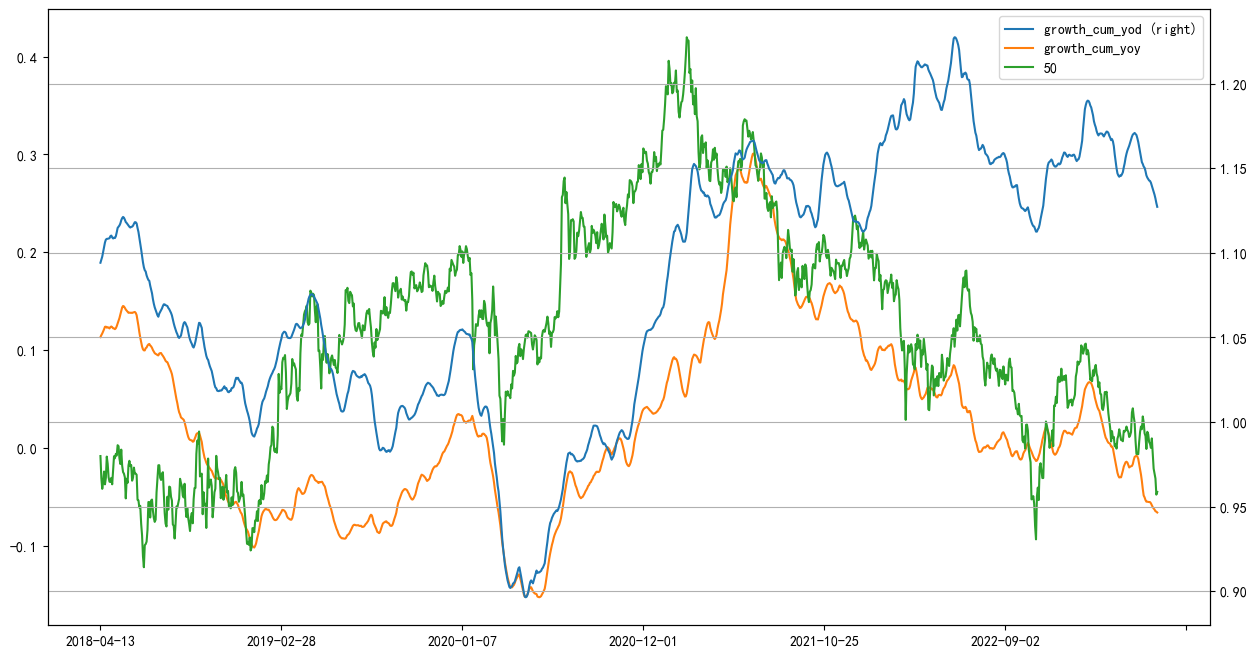

In [113]:
growth.loc[(growth_yoy.index & xy.Index_rets.loc[['50'],'2018-04-13':'2023-06-01'].T.cumsum().index)].rename('growth_cum_yod').plot(figsize=(15,8),secondary_y=True,legend=True)
# growth_yoy.loc[(growth_yoy.index & xy.Index_rets.loc[['300'],'2018-04-13':'2023-06-01'].T.cumsum().index)].rename('growth_chg').pct_change().rolling(50).mean().plot(figsize=(15,8),secondary_y=True)
growth_yoy.loc[(growth_yoy.index & xy.Index_rets.loc[['50'],'2018-04-13':'2023-06-01'].T.cumsum().index)].rename('growth_cum_yoy').plot(figsize=(15,8),legend=True)
xy.Index_rets.loc['50',(growth_yoy.index & xy.Index_rets.loc[['50'],'2018-04-13':'2023-06-01'].T.cumsum().index)].T.cumsum().plot(figsize=(15,8),grid=True,legend=True)

## 消费通胀

In [19]:
LHI = pd.read_csv('LHI.csv',index_col=0).iloc[:,0]

In [318]:
cpi = LHI.pct_change().rolling(20).mean()

<Axes: >

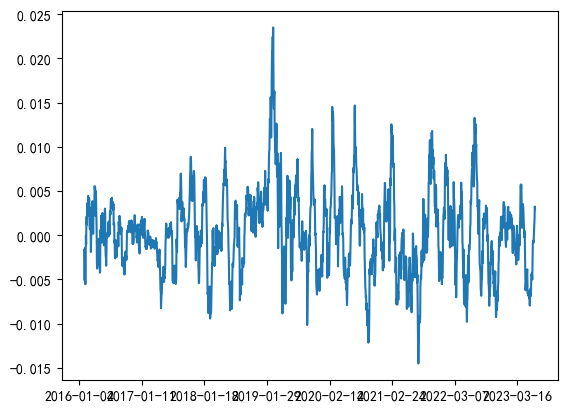

In [319]:
cpi.plot()

In [58]:
LHI_yoy = LHI.pct_change(252)

<Axes: >

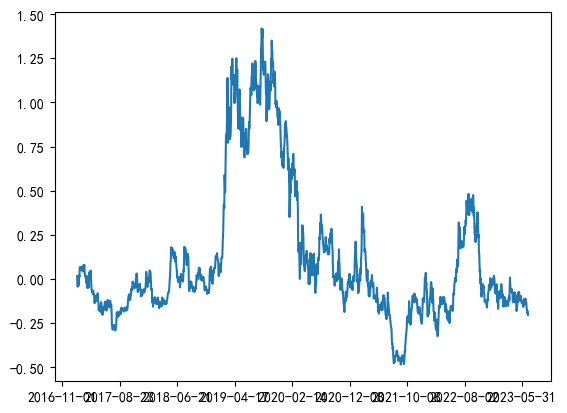

In [310]:
LHI_yoy.plot()

## 生产通胀

In [148]:
RBI = pd.read_csv('RBI.csv',index_col=0).iloc[:,0]
ZCI = pd.read_csv('ZCI.csv',index_col=0).iloc[:,0]
CSI = pd.read_csv('CSI.csv',index_col=0).iloc[:,0]

In [149]:
RBI_yoy = RBI.rolling(20).mean().pct_change(252)
ZCI_yoy = ZCI.rolling(20).mean().pct_change(252)
CSI_yoy = CSI.rolling(20).mean().pct_change(252)

ppi_yoy = pd.concat([
    RBI_yoy.rename('RBI_yoy'),
    ZCI_yoy.rename('ZCI_yoy'),
    CSI_yoy.rename('CSI_yoy'),
],axis=1)

In [187]:
weight_RBI = 1/(RBI.rolling(20).mean().pct_change(252).rolling(252).std())
weight_ZCI = 1/(ZCI.rolling(20).mean().pct_change(252).rolling(252).std())
# weight_CSI = 1/(CSI.rolling(20).mean().pct_change(252).rolling(252).std())

ppi_weight = pd.concat([
    weight_RBI.rename('RBI'),
    weight_ZCI.rename('ZCI'),
    # weight_CSI.rename('CSI'),
],axis=1)

In [188]:
ppi_weight.dropna().T.apply(Singlation)

,2018-02-26,2018-02-27,2018-02-28,2018-03-01,2018-03-02,2018-03-05,2018-03-06,2018-03-07,2018-03-08,2018-03-09,...,2023-06-16,2023-06-19,2023-06-20,2023-06-21,2023-06-26,2023-06-27,2023-06-28,2023-06-29,2023-06-30,2023-07-03
RBI,0.502739,0.502389,0.502112,0.501908,0.501759,0.501646,0.501554,0.501461,0.501368,0.501231,...,0.720136,0.719804,0.719466,0.719124,0.718799,0.718501,0.718229,0.71798,0.717737,0.717499
ZCI,0.497261,0.497611,0.497888,0.498092,0.498241,0.498354,0.498446,0.498539,0.498632,0.498769,...,0.279864,0.280196,0.280534,0.280876,0.281201,0.281499,0.281771,0.28202,0.282263,0.282501


In [190]:
RBI_yod = RBI.rolling(20).mean().pct_change(1)
ZCI_yod = ZCI.rolling(20).mean().pct_change(1)
# CSI_yod = CSI.rolling(20).mean().pct_change(1)

ppi_yod = pd.concat([
    RBI_yod.rename('RBI'),
    ZCI_yod.rename('ZCI'),
    # CSI_yod.rename('CSI'),
],axis=1)

In [294]:
_ppi_yoy = ((ppi_yod.dropna().T * ppi_weight.dropna().T.apply(Singlation)).sum().T )

In [300]:
ppi = _ppi_yoy[_ppi_yoy!=0]

<Axes: >

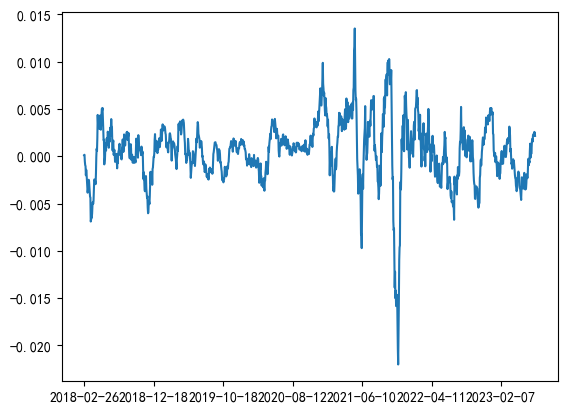

In [306]:
ppi.plot()

<Axes: >

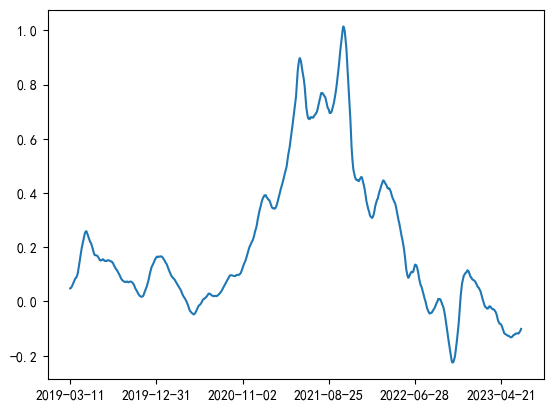

In [301]:
(ppi+1).cumprod().pct_change(252)[(ppi+1).cumprod().pct_change(252)!=0].dropna().plot()

## 信用利差

In [28]:
# CpnBondAA
file_path = 'BondAA1_3.txt'
data_dict = read_json_from_file(file_path)
CpnBondAA = trans_keys(data_dict)

In [29]:
# CDBBond
file_path = 'BondCD1_3.txt'
data_dict = read_json_from_file(file_path)
CDBBond = trans_keys(data_dict)

In [30]:
# CpnBondAAyied
file_path = 'BondAA1_3yield.txt'
data_dict = read_json_from_file(file_path)
CpnBondAA_yied = trans_keys(data_dict)

In [31]:
# CDBBondyied
file_path = 'BondCD1_3yield.txt'
data_dict = read_json_from_file(file_path)
CDBBond_yield = trans_keys(data_dict)

In [323]:
Credit_margin = (CpnBondAA_yied.loc[(CpnBondAA_yied.index & CDBBond_yield.index)] - CDBBond_yield.loc[(CpnBondAA_yied.index & CDBBond_yield.index)]) / 100

<Axes: >

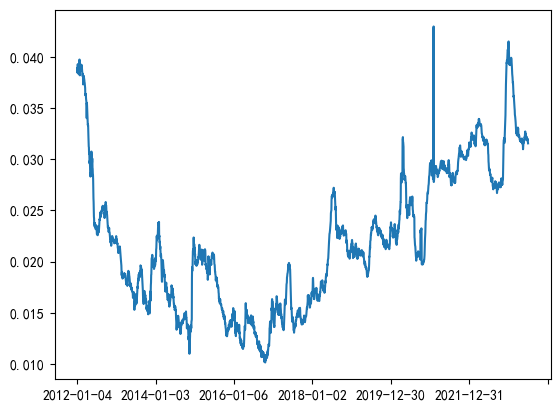

In [333]:
(Credit_margin).plot()

## 期限利差

In [34]:
# CGBond1_3
file_path = 'BondCG1_3yield.txt'
data_dict = read_json_from_file(file_path)
BondCG1_3yield = trans_keys(data_dict)

In [35]:
# CGBond7_10
file_path = 'BondCG7_10yield.txt'
data_dict = read_json_from_file(file_path)
BondCG7_10yield = trans_keys(data_dict)

In [ ]:
# CNBond10
file_path = 'BondCN10yield.txt'
data_dict = read_json_from_file(file_path)
BondCN10yield = trans_keys(data_dict)

BondCN10yield.plot()

In [ ]:
xy.loc

In [334]:
Period_margin = (BondCG7_10yield - BondCG1_3yield) / 100

<Axes: >

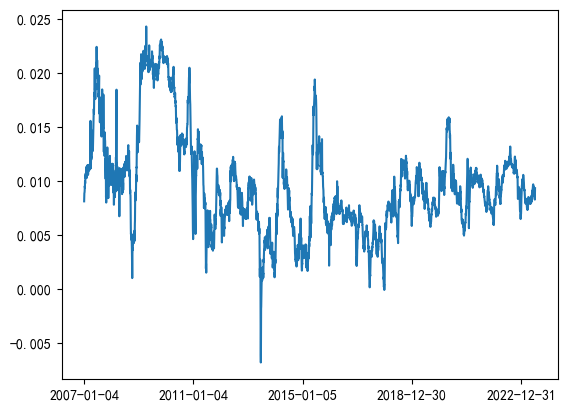

In [335]:
Period_margin.plot()

## 汇率

In [27]:
LDAU = pd.read_csv('XAU.csv',index_col=0).iloc[:,0]
SHAU = pd.read_csv('SHAU.csv',index_col=0,header=None).iloc[:,0]

RateGap = (LDAU/SHAU).pct_change()

<Axes: >

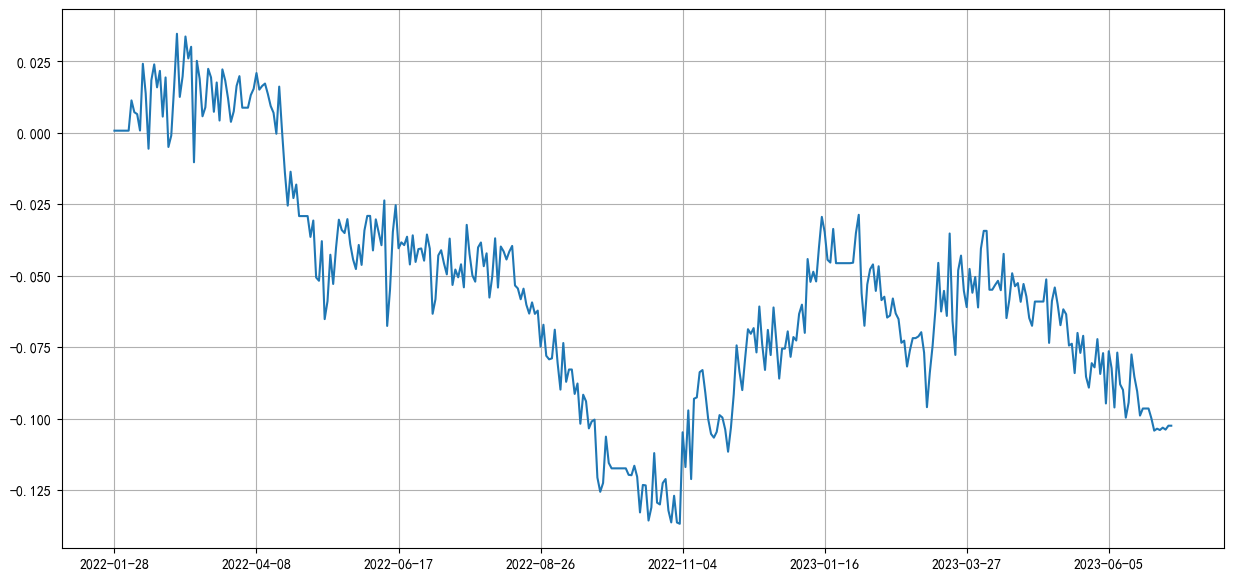

In [30]:
RateGap.loc['2022-01-28':'2023-08-04'].cumsum().plot(figsize=(15,7),grid=True)

### 整合

In [345]:
Macro_Factors = pd.concat([
    growth.rename('growth'),
    ppi.rename('ppi'),
    cpi.dropna().rename('cpi'),
    Credit_margin.rename('Credit_margin'),
    Period_margin.rename('Period_margin'),
    RateGap.dropna().rename('RateGap'),
],axis=1).dropna()

<Axes: >

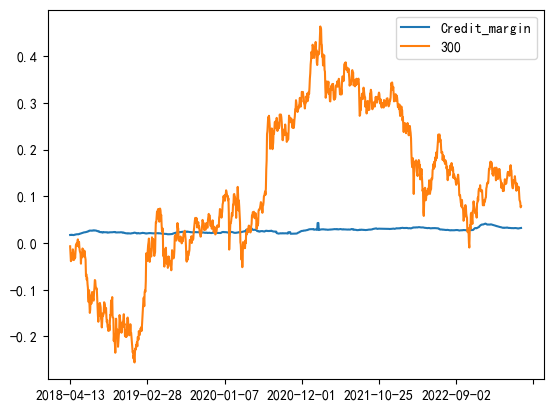

In [346]:
pd.concat([
    Macro_Factors['Credit_margin'].loc[(Macro_Factors['Credit_margin'].index & xy.Index_rets.loc[['300'],'2018-04-13':'2023-06-01'].T.cumsum().index)].rename('Credit_margin'),
    xy.Index_rets.loc[['300'],'2018-04-13':'2023-06-01'].T.cumsum().loc[(Macro_Factors['Credit_margin'].index & xy.Index_rets.loc[['50'],'2018-04-13':'2023-06-01'].T.cumsum().index)]
],axis=1).plot()

### 用于时序预测

In [544]:
_XY = pd.concat([
    Macro_Factors,
    xy.Index_rets.iloc[:4,:].T
],axis=1).dropna()

In [545]:
import random
import statsmodels.api as sm
from scipy import stats

In [614]:
XY = _XY.rolling(20).sum().dropna()

In [602]:
same_idx = Index_ENP_fn.index & XY.index
NP_Y = Index_ENP_fn.rolling(20).sum().dropna().loc[same_idx]

In [623]:
coefficients = []
residuals = []
r_squared = []
tvalues = []

coefficients1 = []
residuals1 = []
r_squared1 = []
tvalues1 = []

# Boostrap Sampling
arg_array = np.array(range(XY.shape[0]))

for _ in tqdm(range(1000)):
    sample_size = random.randint(200,400)
    bootstrap_sample_arg = np.random.choice(arg_array, size=sample_size, replace=True)
    Xs = np.array(XY.iloc[bootstrap_sample_arg,:6])
    
    # Intercept
    Xs = sm.add_constant(Xs)
    Y = np.array(XY.iloc[bootstrap_sample_arg,9])
    # Y1 = np.array(NP_Y.iloc[bootstrap_sample_arg,9-6])
    
    # ols
    model = sm.OLS(Y, Xs)
    results = model.fit()
    
    # model1 = sm.OLS(Y1, Xs)
    # results1 = model1.fit()
    
    # 获取回归系数
    coefficients.append(results.params)
    # coefficients1.append(results1.params)

    # 获取残差
    residuals.append(results.resid)
    # residuals1.append(results1.resid)

    # 获取R平方
    r_squared.append(results.rsquared)
    # r_squared1.append(results1.rsquared)

    # T统计量
    tvalues.append(results.tvalues)
    # tvalues1.append(results1.tvalues)
    
betas = np.array(tvalues)
R2 = np.array(r_squared)
# betas1 = np.array(tvalues1)
# R21 = np.array(r_squared1)

for j, n in enumerate(XY.iloc[bootstrap_sample_arg,:6].columns):
    T_median = np.median(betas[:,j])
    # T_median1 = np.median(betas1[:,j])
    
    print(f"{n}_T统计量:", T_median)
    # print(f"{n}_T统计量1:", T_median1)
    
R2_median = np.median(R2)
print("R2:", R2_median)
# R2_median1 = np.median(R21)
# print("R21:", R2_median1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1205.66it/s]

growth_T统计量: -1.5331638076573366
ppi_T统计量: 3.378287954364588
cpi_T统计量: -4.004979671426495
Credit_margin_T统计量: 0.21144924088993744
Period_margin_T统计量: -0.9658519953968083
RateGap_T统计量: 2.805518514803758
R2: 0.13584954355856949


In [606]:
XY.iloc[:,:]

,growth,ppi,cpi,Credit_margin,Period_margin,RateGap,50,300,500,1000
2018-05-31,-0.001322,-0.033501,-0.039547,1.063688,0.480961,-0.023608,-0.092464,-0.068136,-0.045746,-0.032906
2018-06-01,-0.000461,-0.031731,-0.025334,1.068078,0.479889,-0.024090,-0.102260,-0.088121,-0.080181,-0.066401
2018-06-04,0.000784,-0.030654,-0.010335,1.072627,0.478950,-0.023892,-0.068658,-0.063879,-0.077356,-0.074325
2018-06-05,0.002009,-0.028376,0.005256,1.077720,0.478199,-0.023526,-0.047496,-0.045261,-0.062659,-0.063378
2018-06-06,0.003175,-0.024843,0.019994,1.083127,0.477293,-0.022588,-0.057364,-0.053657,-0.074541,-0.077175
...,...,...,...,...,...,...,...,...,...,...
2023-05-24,-0.026447,-0.072245,-0.063614,1.962465,0.483073,0.051199,-0.088208,-0.071317,-0.058242,-0.066472
2023-05-25,-0.026938,-0.075647,-0.071044,1.958050,0.483975,0.052806,-0.081487,-0.064519,-0.059864,-0.069480
2023-05-30,-0.027298,-0.078232,-0.079060,1.954101,0.484990,0.055037,-0.085991,-0.062720,-0.051550,-0.060313
2023-05-31,-0.027541,-0.080587,-0.087590,1.950618,0.486122,0.057610,-0.088044,-0.062556,-0.050716,-0.057590


In [489]:
XY['ppi'].corr(XY['300'])

0.09169556181228011

<Axes: >

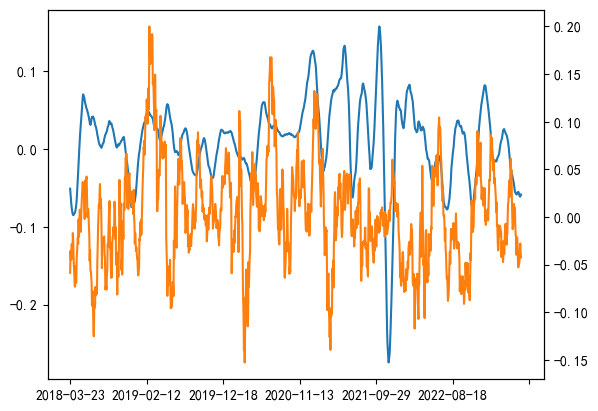

In [490]:
XY['ppi'].plot()
XY['300'].plot(secondary_y=True)

<Axes: >

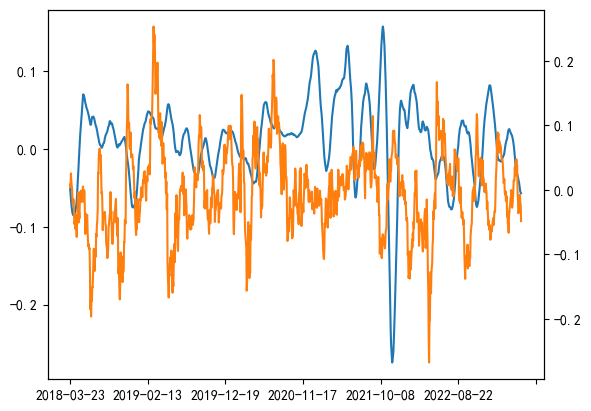

In [562]:
XY['ppi'].plot()
XY['1000'].plot(secondary_y=True)

In [582]:
_XY['ppi'].corr(_XY['1000'].shift(-1))

-0.07140518449135531

In [586]:
_XY['ppi'].sort_values()

2021-11-16   -0.022025
2021-11-15   -0.020327
2021-11-17   -0.018924
2021-11-12   -0.018003
2021-11-08   -0.015851
                ...   
2021-10-11    0.010280
2021-05-13    0.010444
2021-05-10    0.011164
2021-05-11    0.011589
2021-05-12    0.013513
Name: ppi, Length: 1199, dtype: float64

In [594]:
_XY['ppi'][_XY['ppi']<-0.01]

2021-11-01   -0.010406
2021-11-02   -0.013898
2021-11-03   -0.012212
2021-11-04   -0.015013
2021-11-05   -0.014205
2021-11-08   -0.015851
2021-11-09   -0.015824
2021-11-10   -0.015388
2021-11-11   -0.014663
2021-11-12   -0.018003
2021-11-15   -0.020327
2021-11-16   -0.022025
2021-11-17   -0.018924
2021-11-18   -0.015232
2021-11-19   -0.010960
Name: ppi, dtype: float64

shrh: 0.0 win%: 0.5437100213219617 gainloss%: -0.865005262376684 469
shrh: -0.002 win%: 0.5362318840579711 gainloss%: -0.9159357966537605 207
shrh: -0.004 win%: 0.5967741935483871 gainloss%: -0.8324726516954515 62
shrh: -0.006 win%: 0.5806451612903226 gainloss%: -0.9711495732654154 31
shrh: -0.008 win%: 0.65 gainloss%: -1.4266532963368013 20
shrh: -0.01 win%: 0.6666666666666666 gainloss%: -1.2040669748418058 15
shrh: -0.012 win%: 0.6153846153846154 gainloss%: -1.1738425861958568 13
shrh: -0.014 win%: 0.6363636363636364 gainloss%: -1.4738561678795945 11
shrh: -0.016 win%: 0.5 gainloss%: -2.235335955397379 4
shrh: -0.018 win%: 0.5 gainloss%: -2.235335955397379 4
shrh: -0.02 win%: 0.0 gainloss%: nan 2
shrh: -0.022 win%: 0.0 gainloss%: nan 1


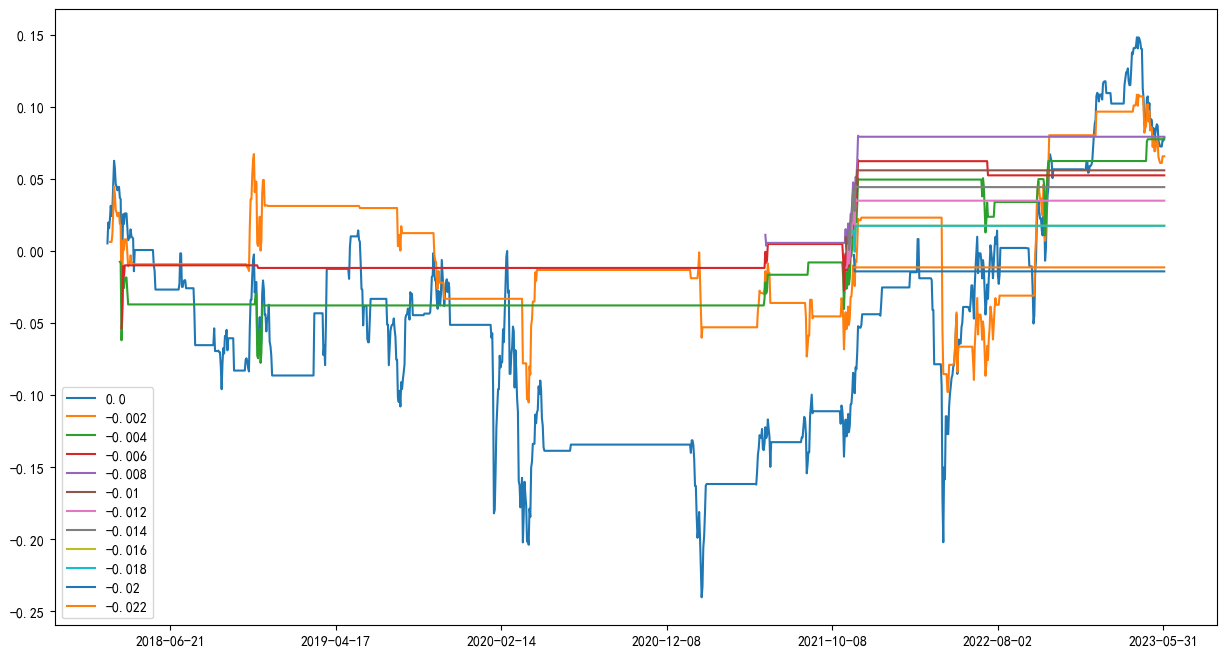

In [597]:
idx_name = '1000'
for i in range(100)[::2]:
    i = 0 - i / 1000

    same_dt = set(_XY['ppi'].index) & set(_XY[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[_XY['ppi'][(_XY['ppi']<i)].index&same_dt]
    
    if len(ts_ret) < 1:
        continue
    
    # if i < 0.57:
    #     continue
    
    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio,ts_ret.shape[0] )
    
    pd.Series(ts_ret.cumsum().rename(i),xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))

In [500]:
NP_TTM_files =  os.listdir(r'E:\PyProject\FPY1\Data\NP_TTM')

NP_TTM_files_lst = []
for f in NP_TTM_files:
    NP_TTM_files_lst.append(pd.read_csv(fr'E:\PyProject\FPY1\Data/NP_TTM/{f}',index_col=0).astype('float32'))
    # if str(f[-8:-4]) == '2021':
    #     break
st_NP_TTM = pd.concat(NP_TTM_files_lst,axis=1)
st_NP_TTM = st_NP_TTM.mask(st_NP_TTM==0.0000000,np.nan).sort_index()    
st_NP_TTM.columns = [str(d)[:10] for d in pd.to_datetime(st_NP_TTM.columns)]
st_NP_TTM = st_NP_TTM[~st_NP_TTM.index.duplicated()]

In [504]:
NP_files =  os.listdir(r'E:\PyProject\FPY1\Data/NP')

NP_files_lst = []
for f in NP_files:
    NP_files_lst.append(pd.read_csv(fr'E:\PyProject\FPY1\Data/NP/{f}',index_col=0).dropna(axis=1, how='all').iloc[1:,:].astype('float32'))
st_NP = pd.concat(NP_files_lst,axis=1)
st_NP = st_NP.mask(st_NP==0.0000000,np.nan).sort_index()
st_NP.columns = [str(d)[:10] for d in pd.to_datetime(st_NP.columns)]
st_NP = st_NP[~st_NP.index.duplicated()]

In [508]:
(st_NP * (xy.weights50)).loc[:,'2017-01-03':].dropna(how='all').mean()

2017-01-03    8.402527e+08
2017-01-04    8.402527e+08
2017-01-05    8.402527e+08
2017-01-06    8.402527e+08
2017-01-07             NaN
                  ...     
2023-05-16             NaN
2023-05-17             NaN
2023-05-18             NaN
2023-05-19             NaN
2023-05-22             NaN
Length: 2327, dtype: float64

In [509]:
(((st_NP_TTM * xy.weights50).loc[:,'2017-01-03':].dropna(how='all').mean()) / (st_NP * (xy.weights50)).loc[:,'2017-01-03':].dropna(how='all').mean()-1)

2017-01-03   -0.000539
2017-01-04   -0.001410
2017-01-05   -0.001695
2017-01-06   -0.001695
2017-01-07         NaN
                ...   
2023-05-16         NaN
2023-05-17         NaN
2023-05-18         NaN
2023-05-19         NaN
2023-05-22         NaN
Length: 2327, dtype: float64

In [510]:
pre_raise50 = ((st_NP_TTM * xy.weights50).loc[:,'2017-01-03':].dropna(how='all').mean() / (st_NP * (xy.weights50)).loc[:,'2017-01-03':].dropna(how='all').mean()-1).rename('50').dropna()
pre_raise300 = ((st_NP_TTM * xy.weights300).loc[:,'2017-01-03':].dropna(how='all').mean() / (st_NP * (xy.weights300)).loc[:,'2017-01-03':].dropna(how='all').mean()-1).rename('300').dropna()
pre_raise500 = ((st_NP_TTM * xy.weights500).loc[:,'2017-01-03':].dropna(how='all').mean() / (st_NP * (xy.weights500)).loc[:,'2017-01-03':].dropna(how='all').mean()-1).rename('500').dropna()
pre_raise1000 = ((st_NP_TTM * xy.weights1000).loc[:,'2017-01-03':].dropna(how='all').mean() / (st_NP * (xy.weights1000)).loc[:,'2017-01-03':].dropna(how='all').mean()-1).rename('1000').dropna()

In [512]:
Index_ENP_fn = pd.concat([
    pre_raise50.rename('50'),
    pre_raise300.rename('300'),
    pre_raise500.rename('500'),
    pre_raise1000.rename('1000')
],axis=1)

<Axes: >

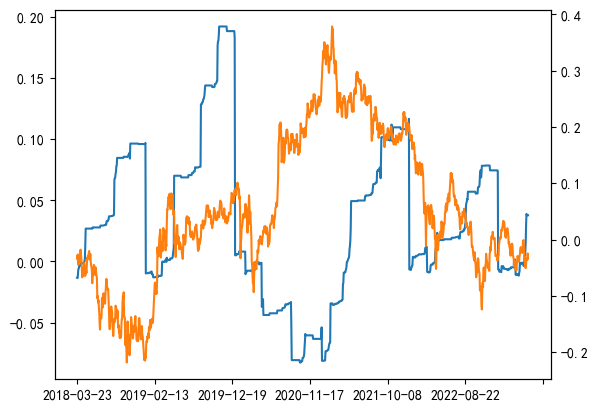

In [547]:
Index_ENP_fn.loc[same_idx,'300'].plot()
_XY.loc[same_idx,'300'].cumsum().plot(secondary_y=True)

In [273]:
from sklearn.linear_model import LinearRegression as LR

def linearRegresser(X_train, y_train):
    return LR().fit(X_train, y_train)

In [280]:
model = np.linalg.lstsq(XY.iloc[:,:6], XY.loc[:,'300'],rcond=None)[0].T
    
#.loc[X_test.index.isin(['sz100','2000'])]
# _pred0 = np.matmul(model, X_test.dropna().T).T

In [281]:
model

array([-1.46278085e-02,  1.89798878e-03, -7.67061625e-04,  1.34305141e-06,
        2.06024287e-04,  6.69571509e-02])